In [44]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
np.set_printoptions(precision = 6,suppress=True)
from scipy.optimize import LinearConstraint, minimize

# Checkpoint 1: Function Definition (1 mark)


In the following cell, you need to define $f(x)$, $g_1(x)$, and $g_2(x)$:

In [45]:
def f(x):
    # Objective function
    return x[0]**2 + (x[1] - 3)**2
def g_1(x):
    # Constraint 1
    return -2 * x[0] + x[1]**2
def g_2(x):
    # Constraint 2
    return 5 * x[0] + (x[1] - 1)**2 - 15

In the following cell, you need to define $\nabla f(x)$, $\nabla g_1(x)$, and $\nabla g_2(x)$:

In [46]:
def nablaf(x):
    # Gradient of f(x)
    return np.array([2 * x[0], 2 * (x[1] - 3)])
def nablag_1(x):
    # Gradient of g1(x)
    return np.array([-2, 2 * x[1]])
def nablag_2(x):
    # Gradient of g2(x)
    return np.array([5, 2 * (x[1] - 1)])

In the following cell, you need to define $\nabla L(x,\lambda)$, and $\nabla^2 L(x,\lambda)$:

In [47]:
def nablaL(x, lamb):
    # Gradient of the Lagrangian
    grad_f = nablaf(x)
    grad_g1 = nablag_1(x)
    grad_g2 = nablag_2(x)
    return grad_f + lamb[0] * grad_g1 + lamb[1] * grad_g2
def nabla2L(x, lamb):
    # Hessian of the Lagrangian
    hessian_f = np.array([[2, 0], [0, 2]])  # ∇²f(x)
    hessian_g1 = np.array([[0, 0], [0, 2]])  # ∇²g1(x)
    hessian_g2 = np.array([[0, 0], [0, 2]])  # ∇²g2(x)
    return hessian_f + lamb[0] * hessian_g1 + lamb[1] * hessian_g2

Print the value of the 8 function define above at point $x_0 = (0,0)$ and $λ_0 = (0,0)$ and $x_0 = (1,1)$ and $λ_0 = (1,1)$

In [48]:
#DO NOT MAKE CHANGES TO THIS ENTIRE CELL
x0 = [0,0]
lamb0 = [0,0]
print("f(x0)  : {0:5.2f}\ng_1(x0): {1:5.2f}\ng_2(x0): {2:5.2f}".format(f(x0),g_1(x0),g_2(x0)))
print("∇f(x0) :",nablaf(x0),"\n∇g1(x0):",nablag_1(x0),"\n∇g2(x0):",nablag_2(x0))
print("∇L(x0,λ0) :",nablaL(x0,lamb0))
print("∇L2(x0,λ0):\n", nabla2L(x0,lamb0))
print()
x1 = [1,1]
lamb1 = [1,1]
print("f(x1)  : {0:5.2f}\ng_1(x1): {1:5.2f}\ng_2(x1): {2:5.2f}".format(f(x1),g_1(x1),g_2(x1)))
print("∇f(x1) :",nablaf(x1),"\n∇g1(x1):",nablag_1(x1),"\n∇g2(x1):",nablag_2(x1))
print("∇L(x1,λ1) :",nablaL(x1,lamb1))
print("∇L2(x1,λ1):\n", nabla2L(x1,lamb1))

f(x0)  :  9.00
g_1(x0):  0.00
g_2(x0): -14.00
∇f(x0) : [ 0 -6] 
∇g1(x0): [-2  0] 
∇g2(x0): [ 5 -2]
∇L(x0,λ0) : [ 0 -6]
∇L2(x0,λ0):
 [[2 0]
 [0 2]]

f(x1)  :  5.00
g_1(x1): -1.00
g_2(x1): -10.00
∇f(x1) : [ 2 -4] 
∇g1(x1): [-2  2] 
∇g2(x1): [5 0]
∇L(x1,λ1) : [ 5 -2]
∇L2(x1,λ1):
 [[2 0]
 [0 6]]


# Checkpoint 2: QP subproblem (1 Mark)


In the following cell, you need to write a define the quadratic programming (QP) subproblem objective that take in $x,P,Q$ as variables and output
\begin{equation}
QP(x) = \frac{1}{2} x^TPx + q^Tx
\end{equation}

In [49]:
def QPSubproblem(x, P, q):
    x = np.array(x)
    P = np.array(P)
    qt = np.transpose(np.array(q))
    xt = np.transpose(x)
    return 0.5 * np.dot(x.T, np.dot(P,x)) + np.dot(qt,x)

In the following cell, you need to find $P$, $q$, $G$, $h_l$, $h_u$, such that:
\begin{equation}
  \begin{array}{rlcrl}
     \displaystyle\min_{s_k}& \displaystyle\frac{1}{2} (s_k)^TPs_k + q^Ts_k &=&\displaystyle\min_{s_k}& \displaystyle\frac{1}{2} (s_k)^T\nabla^2L(x_k,\lambda_k)s_k + (\nabla f(x_k))^Ts_k\\
    \text{s.t.} &H_l \leq GΔx \leq H_u &  & \text{s.t.}& g_1(x_k) + \nabla g_1(x_k)s_k \leq 0  \\
                && && g_2(x_k) + \nabla g_2(x_k)s_k \leq 0
  \end{array}
\end{equation}

In [50]:
def calcsk(x,lamb):
    # Compute the Hessian of the Lagrangian with respect to x and lamb
    P = nabla2L(x, lamb)
    # Compute the gradient of the objective function
    q = nablaf(x)
    # Compute the gradient of inequality constraints
    G = np.array([nablag_1(x), nablag_2(x)])
    # Compute the upper and lower bounds for the constraints
    h_u = -np.array([g_1(x), g_2(x)])
    h_l = -np.inf * np.ones(G.shape[0])
    # Solve the quadratic programming
    res = sp.optimize.minimize(QPSubproblem,x, constraints = [sp.optimize.LinearConstraint(G,h_l,h_u)], args = (P,q))
    return np.array(res.x)

Print the value of ```calcsk(x,lamb)``` for $x_0 = (0,0),\lambda_0 = (0,0)$ and $x_1 = (1,1),\lambda_1 = (1,1)$


In [51]:
#DO NOT MAKE CHANGES TO THIS ENTIRE CELL
x0 = [0,0]
lamb0 = [0,0]
print(calcsk(x0,lamb0))

x1 = [1,1]
lamb1 = [1,1]
print(calcsk(x1,lamb1))

[0. 3.]
[-0.125  0.375]


# Checkpoint 3: SQP Iteration (1 Mark)



In the following cell, your task is to write a function to check the KKT condition for optimality. The function take in $x^{(k)}$ and $\lambda^{(k)}$ and should only return $\color{red}{\texttt{True}}$ if all KKT conditions are met, and $\color{red}{\texttt{False}}$ otherwise. The function should also use a (```epsilon```) $\varepsilon$ parameter is used to handle precision.
For example, $f(x) \approx 0 \Leftrightarrow |f(x)|< \varepsilon$, $f(x) \lessapprox 0 \Leftrightarrow f(x)< \varepsilon$

In [54]:
def checkKKT(x, s, epsilon):
    # Compute components of the gradient of the Lagrangian
    grad_L = nablaf(x) + lamb[0] * nablag_1(x) + lamb[1] * nablag_2(x)

    # KKT Conditions grouped for clarity
    kkt_conditions = [
        # Stationarity condition
        np.all(np.abs(grad_L) < epsilon),

        # Primal feasibility condition
        g_1(x) <= epsilon,
        g_2(x) <= epsilon,

        # Dual feasibility condition
        lamb[0] >= -epsilon,
        lamb[1] >= -epsilon,

        # Complementary slackness condition
        abs(lamb[0] * g_1(x)) < epsilon,
        abs(lamb[1] * g_2(x)) < epsilon
    ]

    # Return True only if all conditions are satisfied
    return all(kkt_conditions)

In the following cell, you need to:
1.   Calculate $s_k$
2.   Calculate $\lambda_{k+1}$
3.   Calculate $x_{k+1}$

Hint: Use the following equation to calculate $\lambda_{k+1}$:

$\nabla^2L(x_k,\lambda_k)s_k + \nabla\mathbf{g}(x_k)^T\lambda_{k+1} + \nabla f(x_k) = \mathbf{0}^T$




In [55]:
#define initial point
x = np.array([0,0]).reshape(2,)
lamb = np.array([0,0]).reshape(2,)

#use for plotting
x_iter = x
itercount = 0

while(checkKKT(x,lamb,1e-3) == False):
    #calculate s_k
    s_k = calcsk(x, lamb)

    #calculate lambda_k+1
    grad_g = np.array([nablag_1(x), nablag_2(x)])
    lambda_update_term = nabla2L(x, lamb) @ s_k + nablaf(x)

    lamb = -np.linalg.solve(grad_g.T, lambda_update_term)

    #calculate x
    x = x + s_k

    #store x iterates for plotting
    x_iter = np.vstack((x_iter,x))
    itercount +=1
    if itercount > 100:
      print("Maximum number of iterations exceeded")
      break


Maximum number of iterations exceeded


Print the optimal point and optimal value


In [56]:
#DO NOT MAKE CHANGES TO THIS ENTIRE CELL
print("x*   :",x)
print("λ*   :",lamb)
print("f(x*): {0:.6f}".format(float(f(x))))

x*   : [1.060437 1.456322]
λ*   : [ 1.060034 -0.000161]
f(x*): 3.507468


# Checkpoint 4: Visualisation (1 Mark)


In the following cell, we visualize the iterations of the SQP algorithm. Here, you need to plot the contour of the objective function $f$, as well as the constraint $g_1 \leq 0$ and $g_2 \leq 0$. The path of the iteration is already plotted.

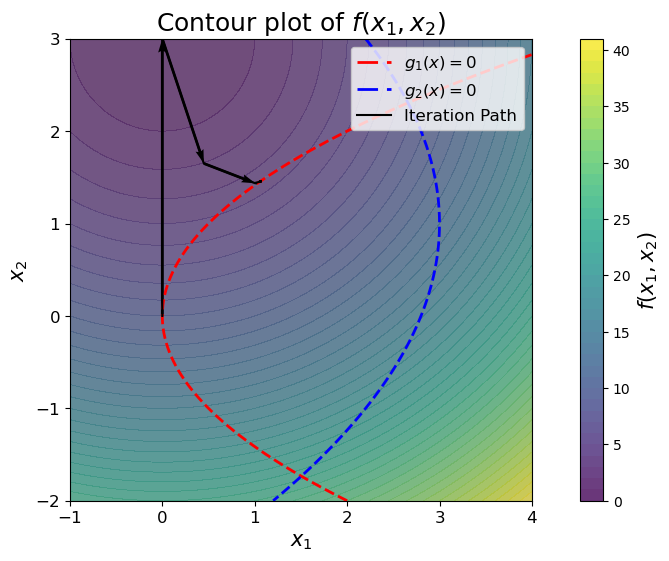

In [58]:
plt.figure(figsize=(8, 6))

x1 = np.linspace(-1, 4, 100)
x2 = np.linspace(-2, 3, 100)
X1, X2 = np.meshgrid(x1, x2)

# Objective function and constraints
F = X1**2 + (X2 - 3)**2
G1 = -2 * X1 + X2**2
G2 = 5 * X1 + (X2 - 1)**2 - 15

# Contour plot of the objective function
contour = plt.contourf(X1, X2, F, levels=50, cmap='viridis', alpha=0.8)
cbar = plt.colorbar(contour)

# Constraint regions and boundaries
contour_g1 = plt.contour(X1, X2, G1, levels=[0], colors='red', linewidths=2, linestyles='dashed')
contour_g2 = plt.contour(X1, X2, G2, levels=[0], colors='blue', linewidths=2, linestyles='dashed')
plt.contourf(X1, X2, (G1 <= 0) & (G2 <= 0), levels=1, colors=['gray'], alpha=0.3)

# Plot the iteration path as a continuous black line
plt.plot(x_iter[:, 0], x_iter[:, 1], '-k', label='Iteration Path (Line)')

# Plot the iteration path with arrows
plt.quiver(
    x_iter[:-1, 0], x_iter[:-1, 1],
    x_iter[1:, 0] - x_iter[:-1, 0],
    x_iter[1:, 1] - x_iter[:-1, 1],
    scale_units='xy', angles='xy', scale=1, color='black'
)

# Add labels to the legend manually
plt.legend(
    [contour_g1.legend_elements()[0][0], contour_g2.legend_elements()[0][0], plt.Line2D([0], [0], color='black')],
    [r'$g_1(x) = 0$', r'$g_2(x) = 0$', 'Iteration Path'],
    fontsize=12
)

# Label axes and title
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'$x_1$', fontsize=15)
plt.ylabel(r'$x_2$', fontsize=15)
plt.title('Contour plot of $f(x_1, x_2)$', fontsize=18)
plt.axis('scaled')
cbar.set_label('$f(x_1, x_2)$', fontsize=15)

# Save and show plot
plt.savefig("plot.pdf", dpi=300, transparent=True)
plt.show()
